# Analyze LR Batch Results

This notebook analyzes the results of 2 experiments: `20241109_lr_batch` and `20241116_test_lr_results_on_full_datasets`. The first experiment was the first attempt at learning rate optimization on different dataset sizes. The second experiment took the best learning rates from the first experiment and trained a model using the full dataset. The hypothesis for this project is that the test accuracy on datasets trained using a subset of the full dataset will produce similar results using the full dataset.


# 0. Imports and configuration

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yaml
import os
import pandas as pd
import seaborn as sns

root = './experiments/20241109_lr_batch/results/'

# 1. Collect results from first experiment

In [2]:
def get_best_lrs(root):
    results = []
    split_id_to_perc = {
        'mnist': 100,
        'mnist_0_75': 75,
        'mnist_0_5': 50,
        'mnist_0_25': 25,
        'mnist_0_1': 10,
    }
    for file in os.listdir(root):
        with open(os.path.join(root, file), "r") as f:
            res = yaml.safe_load(f)
        best_metrics = res['best_metrics']
        lr = best_metrics['config']['train_loop_config']['optimizer_cfg']['args']['lr']
        lr_log = np.log(lr)
        results.append({
            'lr': best_metrics['config']['train_loop_config']['optimizer_cfg']['args']['lr'],
            'lr_log': lr_log,
            'epoch': best_metrics['epoch'],
            'val_loss': best_metrics['val_loss'],
            'split_perc': split_id_to_perc[res['config']['data_cfg']['split_id']]})
    results = pd.DataFrame(results)
    return results
        
results = get_best_lrs(root)

In [3]:
results_agg = results[['lr', 'lr_log', 'val_loss', 'split_perc']].groupby('split_perc').agg(
    {"lr": ["mean", "std"],
     "val_loss": ["mean", "std"],
     "lr_log": ["mean", "std"]})
results_agg['lr_log_exp', 'mean'] = np.exp(results_agg['lr_log', 'mean'])
results_agg['lr_log_exp', 'std'] = np.exp(results_agg['lr_log', 'std'])
results_agg

lr            val_loss              lr_log            \
                mean       std      mean       std      mean       std   
split_perc                                                               
10          0.010485  0.021342  0.011049  0.000808 -8.683894  3.985736   
25          0.008577  0.011781  0.008680  0.000805 -7.045546  3.145583   
50          0.002311  0.004985  0.006521  0.000288 -9.035595  3.083030   
75          0.007107  0.012139  0.006265  0.000396 -7.541997  3.341008   
100         0.005897  0.011892  0.005657  0.000229 -7.892691  2.803567   

           lr_log_exp             
                 mean        std  
split_perc                        
10           0.000169  53.824874  
25           0.000871  23.233209  
50           0.000119  21.824420  
75           0.000530  28.247584  
100          0.000373  16.503417

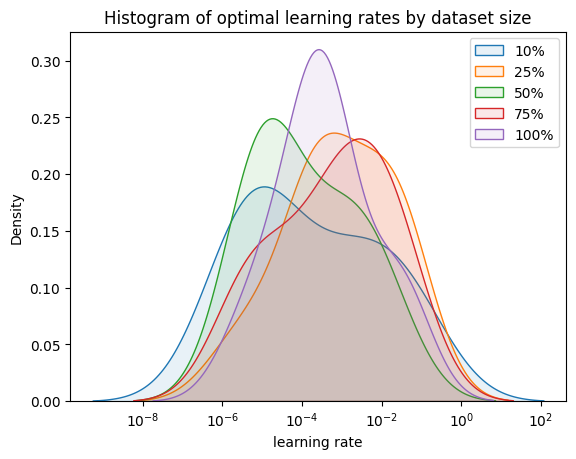

In [4]:
fig, ax = plt.subplots()
for split in sorted(results['split_perc'].unique()):
    sns.kdeplot(results[results['split_perc']==split]['lr'], 
                label=f"{split}%",
                log_scale=True,
                fill=True,
                alpha=0.1)
ax.legend()
ax.set_xlabel("learning rate")
ax.set_title("Histogram of optimal learning rates by dataset size")
fig.savefig("./figures/20241119_optimal_lrs_by_ds_size.png")

Based on the histograms, there is some significant deviation in optimal learning rates when changing dataset size. Many of these show signs of a multimodal distribution. This trial is evidence that using a subset of a dataset may not reliably give the same results as the full dataset.

Text(0.5, 1.0, 'validation loss vs. dataset size')

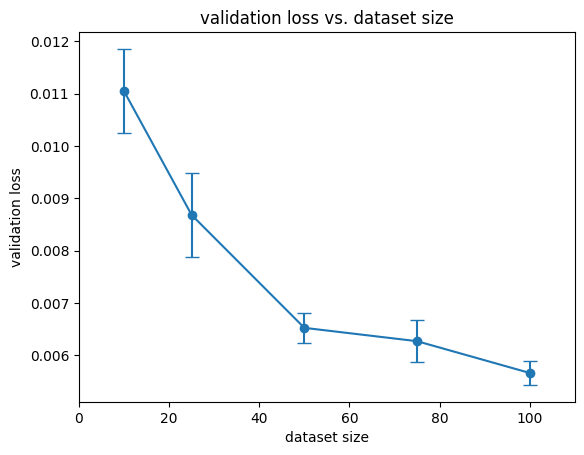

In [5]:

fig, ax = plt.subplots()
ax.scatter(x = results_agg.index,
           y = results_agg['val_loss', 'mean']) 
ax.errorbar(x = results_agg.index,
            y = results_agg['val_loss', 'mean'],
            yerr = results_agg['val_loss', 'std'],
            capsize=5)
ax.set_xlim(0, 110)
ax.set_xlabel("dataset size")
ax.set_ylabel("validation loss")
ax.set_title("validation loss vs. dataset size")

The full dataset appears to have resulted in the best validation loss.

# 2. Train on the full dataset using best hyperparameters from optimization

In this experiment, I'm taking the best learning rates found during all trials in the previous experiment and training on the full dataset. 

In [6]:
root_path = "./experiments/20241116_test_lr_results_on_full_datasets/results/"

def get_results(root_path):
    test_results = []
    split_id_to_perc = {
        'mnist': 100,
        'mnist_0_75': 75,
        'mnist_0_5': 50,
        'mnist_0_25': 25,
        'mnist_0_1': 10,
    }
    for file in os.listdir(root_path):
        with open(os.path.join(root_path, file), "r") as f:
            results = yaml.safe_load(f)
        test_results.append({
            'accuracy': results['testing_data']['test_accuracy'],
            'split': split_id_to_perc[results['config']['data_cfg']['split_id']]
        })
    return test_results
results = get_results(root_path)

Text(0.5, 1.0, 'accuracy vs. dataset size')

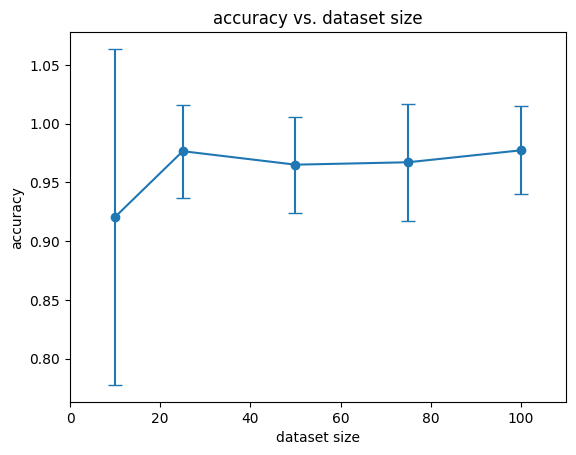

In [7]:
results_df = pd.DataFrame(results).groupby('split').agg({'accuracy': ['mean', 'std']})
fig, ax = plt.subplots()
ax.scatter(x = results_df.index,
           y = results_df['accuracy', 'mean']) 
ax.errorbar(x = results_df.index,
            y = results_df['accuracy', 'mean'],
            yerr = results_df['accuracy', 'std'],
            capsize=5)
ax.set_xlim(0, 110)
ax.set_xlabel("dataset size")
ax.set_ylabel("accuracy")
ax.set_title("accuracy vs. dataset size")

Accuracy appears to stabilize at 25% of dataset.

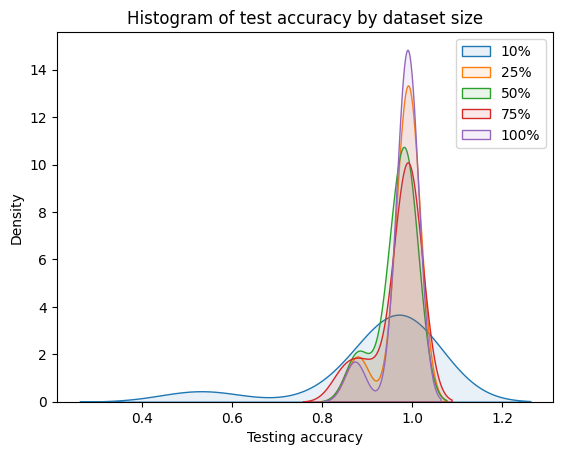

In [8]:
fig, ax = plt.subplots()
results_df = pd.DataFrame(results)
for split in sorted(results_df['split'].unique()):
    sns.kdeplot(results_df[results_df['split']==split]['accuracy'], 
                label=f"{split}%",
                fill=True,
                alpha=0.1)
ax.legend()
ax.set_xlabel("Testing accuracy")
ax.set_title("Histogram of test accuracy by dataset size")
fig.savefig("./figures/20241119_test_accuracy_by_ds_size.png")

While accuracy is stabilized around the 95-100% range for 25%, 50%, 75%, and 100% of the dataset, there is some variation in the peaks which is concerning. Additionally, there appears to be a multimodal distribution. On the surface, I woudl hypothesize that this is due to a local minimum in the loss function that the model can't get out of. If this is the case, then this should be solved using a cyclic learning rate.

Since the distributions are multimodal, I'm going to use a non-parameteric version of the T-test - the Kurskal-Wallis H-test on all means except from the 10% split. The null hypothesis states that the mean rank of the groups are the same. Therefore, a significant result is evidence that the accuracies using the learning rates found using different dataset subset sizes give significantly different results

In [9]:
from scipy.stats import kruskal
split_100 = results_df[results_df['split'] == 100]['accuracy'].to_numpy()
split_75 = results_df[results_df['split'] == 75]['accuracy'].to_numpy()
split_50 = results_df[results_df['split'] == 50]['accuracy'].to_numpy()
split_25 = results_df[results_df['split'] == 25]['accuracy'].to_numpy()

stat, pvalue = kruskal(split_100, split_75, split_50, split_25)
print(f"test statistic: {stat}")
print(f"p value: {pvalue}")

test statistic: 0.6981376907365201
p value: 0.8736418954137878


In this case, we got a p-value of 0.87, meaning at any level of significance we can retain the null hypothesis and use this experiment as evidence that using the learning rate found from doing hyperparameter tuning on a subset of the data might still give good results

# 3. Summary

In this set of experiments, I ran a series of hyperparameter tuning trails using a simple convolutional neural network trained on the MNIST dataset, but using different subsets of the full dataset. I then took the optimal learning rates found from each round of hyperparameter tuning and used that to train models using the full dataset. Afterwards, I compared the accuracy of the models on the MNIST test dataset from each of the split sizes.

On visual inspection, the optimal learning rates found for each subset appeared significantly different. However, the distribution of accuracies had significant overlap using the learning rates found by training on 25%, 50%, 75%, and 100% of the dataset. A Kurskal-Wallis H-Test provided evidence that the mean accuracies of each of the split sizes were not significantly different.

# Next steps

In the next iteration of experiments, I'm going to scale the trails up to multiple datasets and a few different models- mnist, cifar10, and caltech101 for the datasets and a simple convolutional network or resnet for the models. The next objective is to see if the same patterns emerge using different dataset / model combinations.